# Persistent English Auctions - Simulation

A sequential clearing auction mechanism inspired by English auctions for maximising bid transparency and revenue.

We consider the situation in which a NFT artist would like to sell a collection of NFTs. They do not know what would be a fair price and thus resort to an auction.

In a persistent English auction, the auctioneer decides the rate at which NFTs should be sold at e.g 1 NFT per hour. Whilst the auction is active, potential buyers can register bids. In theory, at the end of every hour (a clearing round), a sale is made to the highest bidder. This is done until all pieces are sold.

Lazy evaluation is used to amortise the cost of operating the auction on the blockchain. Before a bid is made, the time gap between the previous transaction is calculated to see if any previous clearing rounds need to be processed. This is inspired by the concept of virtual orders used in [TWAMMs](https://www.paradigm.xyz/2021/07/twamm#the-time-weighted-average-market-maker).

Upon auction close, participants can mint their NFTs and/or claim their funds from unsuccessful bids.

This notebook simulates the running of a persistent English auction due to the simple mechanism to choose the winner every clearing round.

## Dependencies

In [1]:
%pip install names

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 KB 4.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803701 sha256=e49ceacca521ac9586fb65538c03ed9e7a75fe5cc04edba5ee270343186801be
  Stored in directory: /home/jovyan/.cache/pip/wheels/f1/bc/04/55ab9499ea02359ece8b02b4169ebb30aa52d82b84c13fc506
Successfully built names
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Simulated Auction
from pea import PersistentEnglishAuction
from random import randint, uniform, triangular
import numpy as np
import names

# Plotting
import matplotlib.pyplot as plt

## Auction Setup

In [12]:
# Auction configuration presets
TIME_BETWEEN_CLEARING = 2
MAX_CLEARS = 10
AUCTION_START_TIME = 2
BIDS = 50

# Simulation configuration presets
SIMULATION_RUNS = 1000

In [4]:
# Create a completely new auction
def new_auction(time_between_clearing = TIME_BETWEEN_CLEARING,
                max_clears = MAX_CLEARS,
                auction_start_time = AUCTION_START_TIME):
    return PersistentEnglishAuction(time_between_clearing=time_between_clearing,
                                   max_clears=max_clears,
                                   auction_start_time=auction_start_time)

def apply_bids(auction, x, y):
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    
    for i in range(len(x)):
        auction.add_bid(address=names.get_first_name(), bid=y[i], bid_time=x[i])
    auction.close_auction()
    
def get_revenues(auction):
    bidders = auction.get_bidders()
    winners = auction.get_winners()
    all_bids = np.array([bid[0] for bid in (bidders + winners)])
    all_bids = all_bids[np.argsort(all_bids)]
    
    actual_revenue = sum([-winner[0] for winner in winners])
    potential_max_revenue = sum([-bid for bid in all_bids[:MAX_CLEARS]])
    return actual_revenue, potential_max_revenue

def plot_winnings(auction):
    bidders = auction.get_bidders()
    winners = auction.get_winners()
    
    actual_revenue, potential_max_revenue = get_revenues(auction)
    print("Actual maximum revenue: ", actual_revenue)
    print("Potential maximum revenue: ", potential_max_revenue)

    plt.plot([bidder[1] for bidder in bidders], [(-bidder[0]) for bidder in bidders], 'o', color='black')
    plt.plot([winner[1] for winner in winners], [(-winner[0]) for winner in winners], 'o', color="orange")

## Simple Linear Generation

Actual maximum revenue:  851
Potential maximum revenue:  866


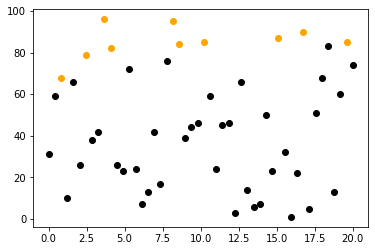

In [5]:
auction = new_auction()

# Generate random bids made in a linear fashion
x = np.linspace(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, BIDS)
y = np.array([randint(1, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [15]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids made in a linear fashion
    x = np.linspace(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, BIDS)
    y = np.array([randint(1, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  882804
Total potential maximum revenue:  897160
Total Efficiency:  98.4 %


## Randomised 2D Generation 

Actual maximum revenue:  868
Potential maximum revenue:  868


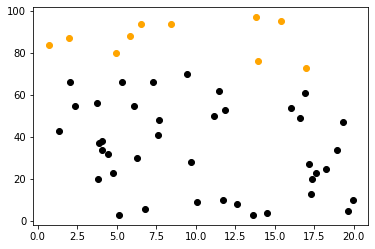

In [7]:
auction = new_auction()

# Generate random bids made in a 2D random fashion
x = np.array([uniform(0, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
y = np.array([randint(1, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [16]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids made in a 2D random fashion
    x = np.array([uniform(0, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
    y = np.array([randint(1, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  878370
Total potential maximum revenue:  895080
Total Efficiency:  98.13 %


## Normal Auction Sniping

Actual maximum revenue:  828.3106886591974
Potential maximum revenue:  873.4383275305822


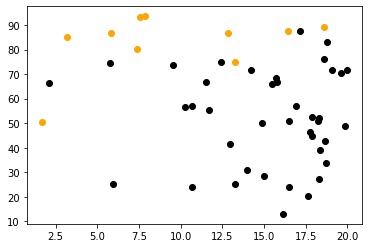

In [8]:
auction = new_auction()

# Generate random bids
x = np.array([triangular(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
y = np.array([triangular(0, 100, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [17]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids
    x = np.array([triangular(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
    y = np.array([triangular(0, 100, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  870901.5937631133
Total potential maximum revenue:  944381.4656902421
Total Efficiency:  92.22 %


## Attuned Auction Sniping

Actual maximum revenue:  924.79446955151
Potential maximum revenue:  936.3398472017616


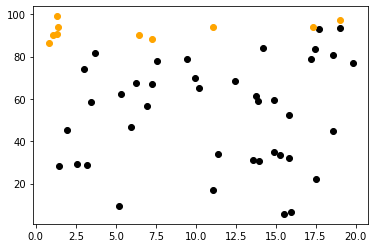

In [9]:
auction = new_auction()

# Generate random bids
x = np.array([[triangular(i * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING) for i in range(0, MAX_CLEARS)][randint(0, MAX_CLEARS - 1)] for _ in range(0, BIDS)])
y = np.array([triangular(0, 100, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [19]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids
    x = np.array([[triangular(i * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING) for i in range(0, MAX_CLEARS)][randint(0, MAX_CLEARS - 1)] for _ in range(0, BIDS)])
    y = np.array([triangular(0, 100, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  932610.9502245624
Total potential maximum revenue:  943351.2160284838
Total Efficiency:  98.86 %
